<a href="https://www.kaggle.com/code/samithsachidanandan/store-sales-prediction-pytorch?scriptVersionId=286001363" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

import torch 
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

In [2]:
df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")


In [3]:
df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


### Basic Statistics¶

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
df.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [6]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
len(df.family.unique())

33

In [8]:
len(df.store_nbr.unique())

54

### Preprocessing

In [9]:
df['store_family'] = df.apply(lambda x: f"{x['store_nbr']}_{x['family']}", axis=1)


In [10]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,store_family
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1_AUTOMOTIVE
1,1,2013-01-01,1,BABY CARE,0.0,0,1_BABY CARE
2,2,2013-01-01,1,BEAUTY,0.0,0,1_BEAUTY
3,3,2013-01-01,1,BEVERAGES,0.0,0,1_BEVERAGES
4,4,2013-01-01,1,BOOKS,0.0,0,1_BOOKS


In [11]:
df_pivoted= df.pivot(index='date', columns='store_family',values='sales')


In [12]:
df_pivoted

store_family,10_AUTOMOTIVE,10_BABY CARE,10_BEAUTY,10_BEVERAGES,10_BOOKS,10_BREAD/BAKERY,10_CELEBRATION,10_CLEANING,10_DAIRY,10_DELI,...,9_MAGAZINES,9_MEATS,9_PERSONAL CARE,9_PET SUPPLIES,9_PLAYERS AND ELECTRONICS,9_POULTRY,9_PREPARED FOODS,9_PRODUCE,9_SCHOOL AND OFFICE SUPPLIES,9_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.000,0.00000,0.000,0.0,0.000000
2013-01-02,3.0,0.0,6.0,396.0,0.0,151.0,0.0,1110.0,101.0,276.0,...,0.0,374.531,482.0,0.0,0.0,651.292,83.00000,0.000,0.0,29.214000
2013-01-03,2.0,0.0,3.0,399.0,0.0,129.0,0.0,970.0,113.0,269.0,...,0.0,400.863,372.0,0.0,0.0,509.496,66.00000,0.000,0.0,25.000000
2013-01-04,2.0,0.0,4.0,460.0,0.0,105.0,0.0,669.0,66.0,92.0,...,0.0,310.878,324.0,0.0,0.0,332.672,57.00000,0.000,0.0,11.000000
2013-01-05,0.0,0.0,3.0,624.0,0.0,112.0,0.0,1093.0,88.0,194.0,...,0.0,447.685,461.0,0.0,0.0,510.919,84.00000,0.000,0.0,28.361000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,2.0,0.0,2.0,1459.0,0.0,76.0,5.0,532.0,251.0,269.0,...,5.0,309.245,373.0,11.0,2.0,525.224,112.10000,1453.078,140.0,23.831000
2017-08-12,2.0,0.0,3.0,1332.0,0.0,113.0,5.0,676.0,255.0,276.0,...,2.0,260.298,400.0,7.0,10.0,383.387,129.90399,1419.264,138.0,16.859001
2017-08-13,0.0,0.0,5.0,1526.0,0.0,119.0,6.0,670.0,270.0,251.0,...,3.0,327.206,510.0,2.0,9.0,412.458,105.16900,1693.607,200.0,20.000000


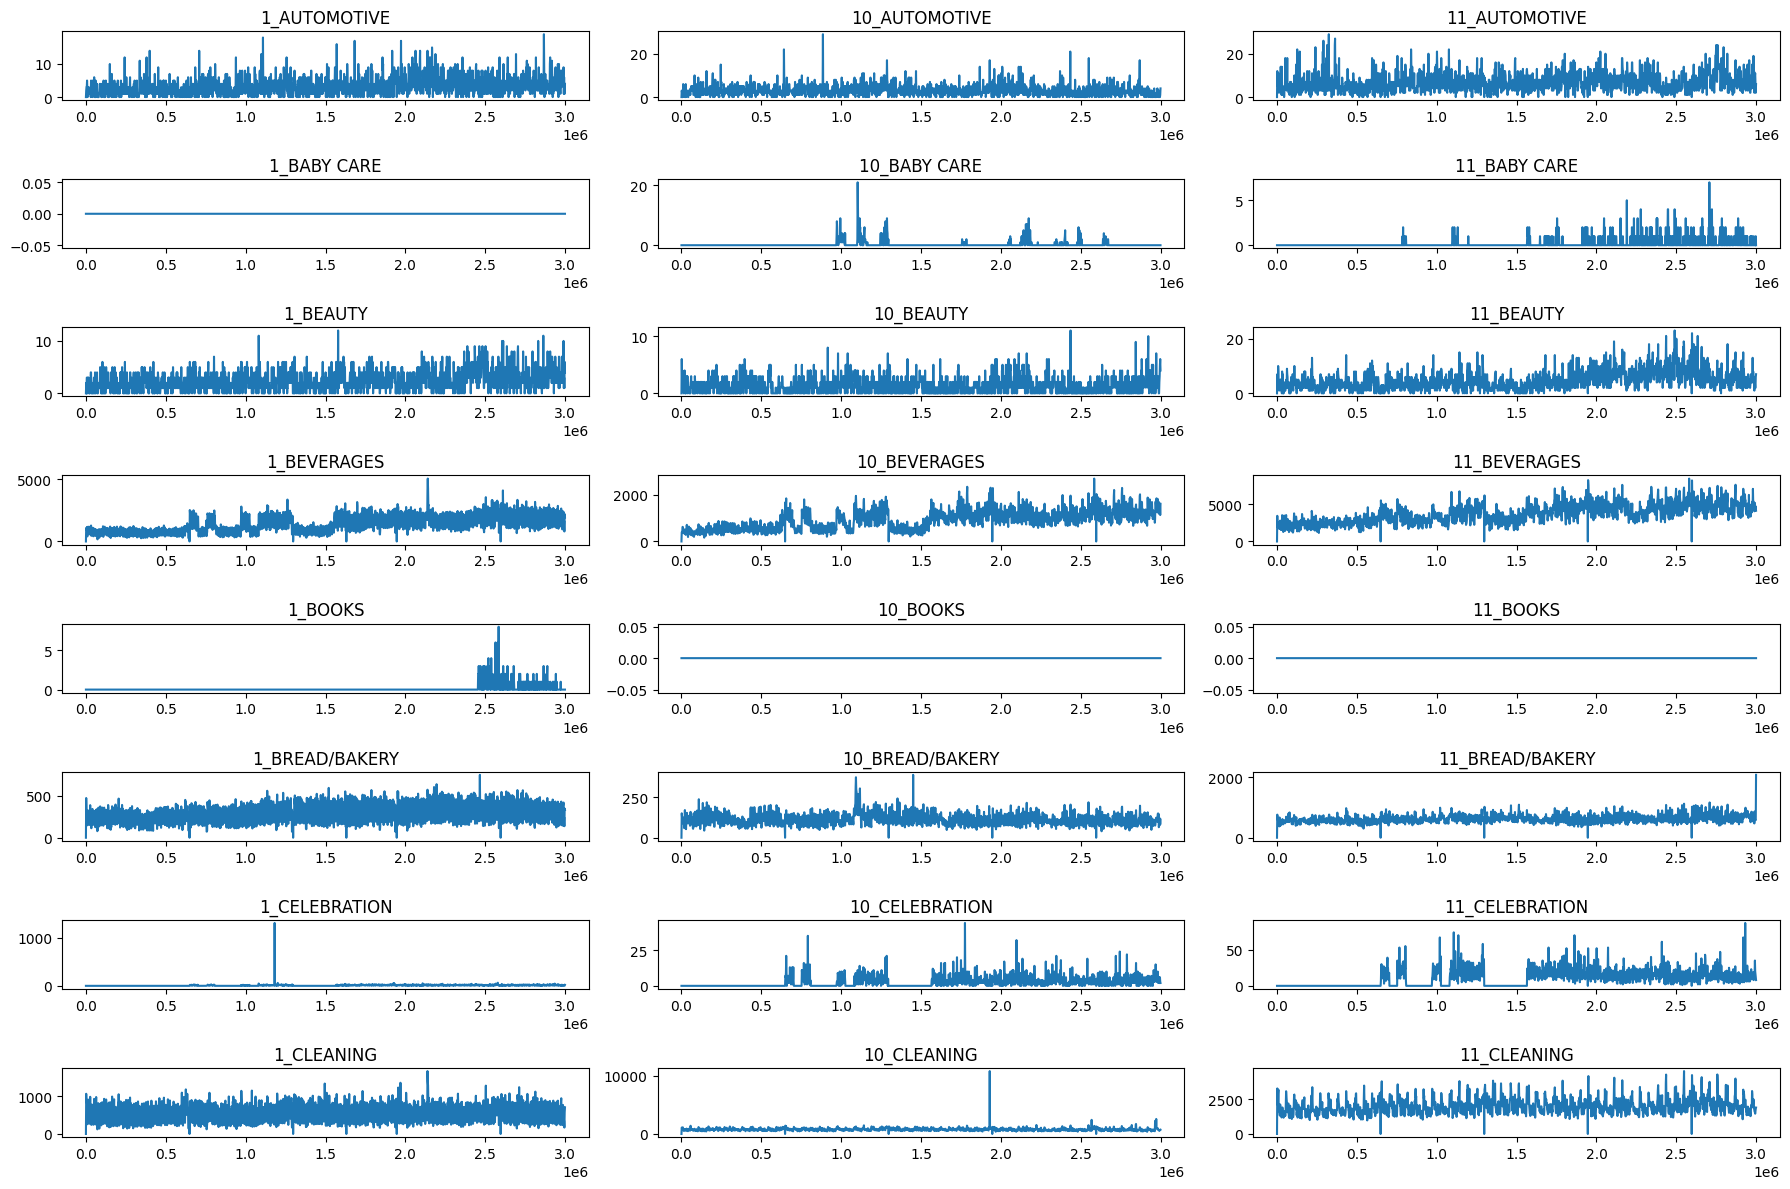

In [13]:
fig, axs = plt.subplots(8,3, figsize=(18,12))

for i in range (8):
    for j in range(3):
        ax= axs[i][j]
        ax.plot(df[(df.family == df.family.unique()[i]) & (df.store_nbr ==df.store_nbr.unique()[j])].sales)
        ax.set_title(f'{df.store_nbr.unique()[j]}_{df.family.unique()[i]}')

plt.tight_layout()

### Scalling the data

In [14]:
scaler = StandardScaler()

train_size = int(0.8 * len(df_pivoted))
train_data = df_pivoted.iloc[:train_size]
test_data = df_pivoted.iloc[train_size:]


train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled =scaler.transform(test_data)


In [15]:
def create_x_y(data, input_length, output_length):
    X, y = [], []

    for i in range(len(data) - input_length -output_length + 1):
        X.append(data[i:i+input_length])
        y.append(data[i+input_length:i+input_length+output_length])

    return np.array(X), np.array(y)

In [16]:
X_train, y_train = create_x_y(train_data_scaled, 120, 16)
X_test, y_test = create_x_y(test_data_scaled, 120, 16)

In [17]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1212, 120, 1782) (1212, 16, 1782)
(202, 120, 1782) (202, 16, 1782)


In [18]:
X_train_tensor = torch.FloatTensor(X_train).cuda()
X_test_tensor = torch.FloatTensor(X_test).cuda()
y_train_tensor = torch.FloatTensor(y_train).cuda()
y_test_tensor = torch.FloatTensor(y_test).cuda()

In [19]:
train_dataset = TensorDataset(X_train_tensor,y_train_tensor )
train_loader = DataLoader(train_dataset, batch_size=32, shuffle = True)

test_dataset = TensorDataset(X_test_tensor,y_test_tensor )
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

### Building and Training Model 

In [20]:
class CausalConv1d(nn.Module):
   
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = weight_norm(nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation
        ))
        
    def forward(self, x):
        x = self.conv(x)
       
        if self.padding > 0:
            x = x[:, :, :-self.padding]
        return x

In [21]:
class ResidualBlock(nn.Module):
  
    def __init__(self, channels, kernel_size, dilation, dropout=0.2):
        super().__init__()
        
        self.conv1 = CausalConv1d(channels, channels, kernel_size, dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = CausalConv1d(channels, channels, kernel_size, dilation)
        self.bn2 = nn.BatchNorm1d(channels)
        self.dropout2 = nn.Dropout(dropout)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        
  
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        
       
        return self.relu(out + residual)

In [22]:
class ImprovedTCNModel(nn.Module):
  
    def __init__(
        self, 
        input_features=54,
        sequence_length=33,
        output_steps=16,
        hidden_channels=[64, 128, 128, 256],
        kernel_size=3,
        dropout=0.2
    ):
        super().__init__()
        
        self.input_features = input_features
        self.sequence_length = sequence_length
        self.output_steps = output_steps
        
     
        self.input_projection = nn.Sequential(
            nn.Linear(input_features, hidden_channels[0]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        

        self.tcn_layers = nn.ModuleList()
        num_layers = len(hidden_channels)
        
        for i in range(num_layers):
            dilation = 2 ** i
            in_ch = hidden_channels[i]
            out_ch = hidden_channels[i]
            
     
            if i > 0 and hidden_channels[i] != hidden_channels[i-1]:
                self.tcn_layers.append(
                    nn.Sequential(
                        CausalConv1d(hidden_channels[i-1], hidden_channels[i], 1, 1),
                        nn.BatchNorm1d(hidden_channels[i]),
                        nn.ReLU()
                    )
                )
            
         
            self.tcn_layers.append(
                ResidualBlock(out_ch, kernel_size, dilation, dropout)
            )
        
       
        self.attention = nn.Sequential(
            nn.Linear(hidden_channels[-1], hidden_channels[-1] // 4),
            nn.Tanh(),
            nn.Linear(hidden_channels[-1] // 4, 1)
        )
        
       
        final_dim = hidden_channels[-1] * 3  
        self.output_projection = nn.Sequential(
            nn.Linear(final_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_steps * input_features)
        )
        
    def forward(self, x):
       
        batch_size = x.size(0)
        
     
        x = self.input_projection(x)
        
    
        x = x.transpose(1, 2)
        
        
        for layer in self.tcn_layers:
            x = layer(x)
        
    
        x = x.transpose(1, 2)
        
    
        attention_weights = F.softmax(self.attention(x), dim=1)
        attended = torch.sum(x * attention_weights, dim=1)
        

        x_transposed = x.transpose(1, 2)  
        avg_pool = F.adaptive_avg_pool1d(x_transposed, 1).squeeze(-1)
        max_pool = F.adaptive_max_pool1d(x_transposed, 1).squeeze(-1)
        
      
        x = torch.cat([attended, avg_pool, max_pool], dim=1)
        
   
        x = self.output_projection(x)
        
      
        x = x.view(batch_size, self.output_steps, self.input_features)
        
        return x


In [23]:
model = ImprovedTCNModel(
    input_features=1782,  
    sequence_length=120,
    output_steps=16,
    hidden_channels=[64, 128, 128, 256],
    dropout=0.05
).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [24]:
for epoch in range(200):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = torch.sqrt(criterion(y_pred, y_batch))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss/len(train_loader):.6f}")

Epoch 5, Loss: 0.880401
Epoch 10, Loss: 0.849744
Epoch 15, Loss: 0.836159
Epoch 20, Loss: 0.824512
Epoch 25, Loss: 0.816751
Epoch 30, Loss: 0.810047
Epoch 35, Loss: 0.803634
Epoch 40, Loss: 0.798570
Epoch 45, Loss: 0.787238
Epoch 50, Loss: 0.767209
Epoch 55, Loss: 0.753509
Epoch 60, Loss: 0.728001
Epoch 65, Loss: 0.717142
Epoch 70, Loss: 0.708364
Epoch 75, Loss: 0.701900
Epoch 80, Loss: 0.695514
Epoch 85, Loss: 0.691101
Epoch 90, Loss: 0.686060
Epoch 95, Loss: 0.682150
Epoch 100, Loss: 0.678777
Epoch 105, Loss: 0.675012
Epoch 110, Loss: 0.672194
Epoch 115, Loss: 0.669558
Epoch 120, Loss: 0.667069
Epoch 125, Loss: 0.663312
Epoch 130, Loss: 0.660873
Epoch 135, Loss: 0.658561
Epoch 140, Loss: 0.657103
Epoch 145, Loss: 0.654268
Epoch 150, Loss: 0.652579
Epoch 155, Loss: 0.650609
Epoch 160, Loss: 0.648981
Epoch 165, Loss: 0.646653
Epoch 170, Loss: 0.644692
Epoch 175, Loss: 0.642874
Epoch 180, Loss: 0.640450
Epoch 185, Loss: 0.638854
Epoch 190, Loss: 0.636540
Epoch 195, Loss: 0.635323
Epoch 

In [25]:
model.eval()

with torch.no_grad():
    test_pred = model(X_test_tensor)
    test_loss = torch.sqrt(criterion(test_pred, y_test_tensor))
    print(test_loss)

tensor(172.2274, device='cuda:0')


### Full Dataset Training 

In [26]:
full_data_scaled = scaler.fit_transform(df_pivoted)

X_full, y_full = create_x_y(full_data_scaled, 120, 16)


X_full_tensor = torch.FloatTensor(X_full).cuda()
y_full_tensor = torch.FloatTensor(y_full).cuda()

full_dataset = TensorDataset(X_full_tensor, y_full_tensor)
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True)


final_model = ImprovedTCNModel(
    input_features=1782,  
    sequence_length=120,
    output_steps=16,
    hidden_channels=[64, 128, 128, 256],
    kernel_size=3,
    dropout=0.05
).cuda()

optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [27]:
for epoch in range(200):
    final_model.train()
    epoch_loss = 0

    for X_batch, y_batch in full_loader:
        optimizer.zero_grad()

        y_pred = final_model(X_batch)

        loss = torch.sqrt(criterion(y_pred, y_batch))
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss : {epoch_loss/len(full_loader)} ")




Epoch 5, Loss : 0.8942667683776544 
Epoch 10, Loss : 0.8632322878253703 
Epoch 15, Loss : 0.8473511861295117 
Epoch 20, Loss : 0.8320559944425311 
Epoch 25, Loss : 0.8243835653577533 
Epoch 30, Loss : 0.8184338917537611 
Epoch 35, Loss : 0.8024980985388463 
Epoch 40, Loss : 0.7827785063763054 
Epoch 45, Loss : 0.7540809074226691 
Epoch 50, Loss : 0.7409518190792629 
Epoch 55, Loss : 0.7293387201367593 
Epoch 60, Loss : 0.7211643639875918 
Epoch 65, Loss : 0.7137831291373895 
Epoch 70, Loss : 0.7090310819294988 
Epoch 75, Loss : 0.7052976257947027 
Epoch 80, Loss : 0.7032746964571427 
Epoch 85, Loss : 0.7005670861322053 
Epoch 90, Loss : 0.6958697109806294 
Epoch 95, Loss : 0.6937482867922101 
Epoch 100, Loss : 0.6919349286021018 
Epoch 105, Loss : 0.6879954958448604 
Epoch 110, Loss : 0.6869158951603637 
Epoch 115, Loss : 0.6840617316109794 
Epoch 120, Loss : 0.6813983771265769 
Epoch 125, Loss : 0.6788276190660438 
Epoch 130, Loss : 0.6756041718989002 
Epoch 135, Loss : 0.674258278340

In [28]:
final_model.eval()

with torch.no_grad():
    last_sequence = torch.FloatTensor(full_data_scaled[-120:]).unsqueeze(0).cuda()
    predictions = final_model(last_sequence)

In [29]:
predictions

tensor([[[-0.7710, -0.1256,  0.5225,  ...,  0.1287,  0.2223, -0.1632],
         [-0.6360, -0.2333,  0.4209,  ...,  0.2715,  0.4940, -0.1203],
         [-0.4609, -0.1866,  0.6430,  ...,  0.3872,  0.7168,  0.2385],
         ...,
         [-0.4599,  0.0302,  0.5818,  ...,  1.0795,  2.3132, -0.1595],
         [-0.6425,  0.0414,  0.3370,  ...,  0.3430,  2.4989,  0.0115],
         [-0.3168, -0.0116,  0.4270,  ...,  0.3235,  2.4511, -0.0676]]],
       device='cuda:0')

In [30]:
predictions  = predictions.cpu().numpy().squeeze(0)
predictions = scaler.inverse_transform(predictions)
predictions = np.maximum(predictions, 0)

In [31]:
predictions

array([[1.0360439e+00, 1.2949812e-01, 2.1081049e+00, ..., 1.0824327e+03,
        1.1003780e+01, 1.5354528e+01],
       [1.3944767e+00, 5.8142063e-03, 1.9650720e+00, ..., 1.2081316e+03,
        1.7058641e+01, 1.5756793e+01],
       [1.8594170e+00, 5.9459489e-02, 2.2775924e+00, ..., 1.3099436e+03,
        2.2024067e+01, 1.9120691e+01],
       ...,
       [1.8621075e+00, 3.0849057e-01, 2.1915703e+00, ..., 1.9192648e+03,
        5.7597992e+01, 1.5389028e+01],
       [1.3771831e+00, 3.2124951e-01, 1.8470829e+00, ..., 1.2710470e+03,
        6.1735649e+01, 1.6991766e+01],
       [2.2421384e+00, 2.6045698e-01, 1.9736753e+00, ..., 1.2538748e+03,
        6.0671085e+01, 1.6250702e+01]], dtype=float32)

In [32]:
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [33]:
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [34]:
test_df['store_family'] = test_df.apply(lambda x: f"{x['store_nbr']}_{x['family']}", axis=1)

In [35]:
dates = sorted(test_df['date'].unique())

In [36]:
dates

['2017-08-16',
 '2017-08-17',
 '2017-08-18',
 '2017-08-19',
 '2017-08-20',
 '2017-08-21',
 '2017-08-22',
 '2017-08-23',
 '2017-08-24',
 '2017-08-25',
 '2017-08-26',
 '2017-08-27',
 '2017-08-28',
 '2017-08-29',
 '2017-08-30',
 '2017-08-31']

In [37]:
pred_df = pd.DataFrame(predictions, index=dates, columns= df_pivoted.columns)

In [38]:
pred_df

store_family,10_AUTOMOTIVE,10_BABY CARE,10_BEAUTY,10_BEVERAGES,10_BOOKS,10_BREAD/BAKERY,10_CELEBRATION,10_CLEANING,10_DAIRY,10_DELI,...,9_MAGAZINES,9_MEATS,9_PERSONAL CARE,9_PET SUPPLIES,9_PLAYERS AND ELECTRONICS,9_POULTRY,9_PREPARED FOODS,9_PRODUCE,9_SCHOOL AND OFFICE SUPPLIES,9_SEAFOOD
2017-08-16,1.036044,0.129498,2.108105,1079.181274,0.000474,99.466759,3.893566,796.255981,313.377960,259.452576,...,2.066636,392.567322,427.762756,6.705982,8.378685,405.169556,96.878731,1082.432739,11.003780,15.354528
2017-08-17,1.394477,0.005814,1.965072,1180.916382,0.000000,98.119217,3.386909,856.167542,247.743179,247.456482,...,1.950041,477.321198,421.550018,6.749573,8.903938,372.275177,97.575989,1208.131592,17.058641,15.756793
2017-08-18,1.859417,0.059459,2.277592,1230.620728,0.000000,101.838585,4.056263,983.031311,253.415268,292.253479,...,2.189762,347.186157,453.892792,7.333931,8.609776,534.094055,102.184952,1309.943604,22.024067,19.120691
2017-08-19,2.488824,0.108520,2.676228,1451.948975,0.000000,121.258263,6.274214,1129.426392,329.325165,282.928101,...,2.991963,426.349335,597.842590,8.922812,11.676360,543.709656,132.464966,1701.608643,25.530346,22.490732
2017-08-20,2.164654,0.223126,2.456589,1425.863281,0.002014,127.412666,3.584376,936.217285,338.429596,291.205811,...,3.421938,406.828583,561.455566,8.655043,11.552814,545.457581,118.501167,1872.575317,23.972273,20.047129
2017-08-21,1.370837,0.102415,2.257436,1085.219482,0.000000,104.624939,2.587671,820.833618,264.027435,237.891739,...,1.112255,344.878632,370.143158,5.460674,6.822525,400.132446,86.940376,1217.365234,28.321236,13.311868
2017-08-22,1.300857,0.218264,1.961040,1101.649658,0.000000,102.954605,3.348603,836.388000,278.430664,241.809586,...,1.519062,334.956390,382.337280,6.339261,7.226181,383.033905,89.783714,1748.578247,34.926281,12.661002
2017-08-23,1.201057,0.000000,1.679515,1019.357178,0.000110,93.330246,3.621383,799.456665,298.353638,232.446014,...,2.059567,350.590424,328.614410,6.973349,7.497345,344.003845,89.300591,990.560486,39.661114,12.900523
2017-08-24,1.601174,0.036228,1.720766,1042.007080,0.000101,88.084641,3.496400,735.775513,221.193634,218.975357,...,2.236750,422.659058,320.041809,6.475127,7.892912,323.872833,89.534363,1086.899414,36.407936,12.183052
2017-08-25,2.346693,0.374042,1.701865,1191.159790,0.003302,86.017242,4.074693,798.624756,236.286957,283.004852,...,2.181579,296.184998,343.009216,6.876183,7.488725,473.502319,99.437126,1157.468994,36.939457,15.321746


In [39]:
pred_long = pred_df.stack().reset_index()
pred_long.columns = ['date', 'store_family', 'sales']

In [40]:
pred_long

,date,store_family,sales
0,2017-08-16,10_AUTOMOTIVE,1.036044
1,2017-08-16,10_BABY CARE,0.129498
2,2017-08-16,10_BEAUTY,2.108105
3,2017-08-16,10_BEVERAGES,1079.181274
4,2017-08-16,10_BOOKS,0.000474
...,...,...,...
28507,2017-08-31,9_POULTRY,387.852264
28508,2017-08-31,9_PREPARED FOODS,103.633934
28509,2017-08-31,9_PRODUCE,1253.874756
28510,2017-08-31,9_SCHOOL AND OFFICE SUPPLIES,60.671085


In [41]:
submission_df = test_df.merge(pred_long, on=['date', 'store_family'], how='left')

In [42]:
submission_df[['id', 'sales']].to_csv('submission.csv', index=False)